In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Import The Library

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras.callbacks import EarlyStopping
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

2.Prepare Data

In [ ]:
local_zip = '/content/drive/MyDrive/data_folder.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data_folder')
zip_ref.close()

base_dir = '/content/data_folder'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_cats_dir = os.path.join(train_dir, 'cat')
train_dogs_dir = os.path.join(train_dir, 'dog')

test_cats_dir = os.path.join(test_dir, 'cat')
test_dogs_dir = os.path.join(test_dir, 'dog')

validation_cats_dir = os.path.join(validation_dir, 'cat')
validation_dogs_dir = os.path.join(validation_dir, 'dog')

In [ ]:
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index = 100
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index - 8:pic_index]
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index - 8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    label = "Cat" if "cat" in img_path else "Dog"
    plt.imshow(img)
    plt.title(label, fontsize=12)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))
validation_generator = datagen.flow_from_directory(validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (150, 150), shuffle = False)
test_generator = datagen.flow_from_directory(test_dir,  batch_size = 20, class_mode = 'binary', target_size = (150, 150), shuffle = False)

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


3. Build An Initial Model, we chose InceptionV3 since the fast convergence



In [ ]:
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable=False

In [ ]:
flatten = layers.Flatten()(base_model.output)

dense1 = layers.Dense(1024, activation='relu')(flatten)

dropout = layers.Dropout(0.2)(dense1)

output = layers.Dense(1, activation='sigmoid')(dropout)

model = models.Model(base_model.input, output)

model.compile(optimizer = optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

es = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

In [ ]:
inceptionv3_hist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 200, epochs = 20, callbacks=[es])

Epoch 1/20
200/200 [==============================] - 25s 73ms/step - loss: 0.6430 - acc: 0.9158 - val_loss: 0.2516 - val_acc: 0.9496
Epoch 2/20
200/200 [==============================] - 13s 66ms/step - loss: 0.2220 - acc: 0.9482 - val_loss: 0.1676 - val_acc: 0.9552
Epoch 3/20
200/200 [==============================] - 14s 68ms/step - loss: 0.1690 - acc: 0.9567 - val_loss: 0.1518 - val_acc: 0.9632
Epoch 4/20
200/200 [==============================] - 13s 65ms/step - loss: 0.1650 - acc: 0.9542 - val_loss: 0.2071 - val_acc: 0.9504
Epoch 5/20
200/200 [==============================] - 12s 61ms/step - loss: 0.1578 - acc: 0.9578 - val_loss: 0.3519 - val_acc: 0.9296
Epoch 6/20
200/200 [==============================] - 18s 92ms/step - loss: 0.1380 - acc: 0.9640 - val_loss: 0.1341 - val_acc: 0.9624
Epoch 7/20
200/200 [==============================] - 13s 63ms/step - loss: 0.1331 - acc: 0.9622 - val_loss: 0.1291 - val_acc: 0.9660
Epoch 8/20
200/200 [==============================] - 12s 60ms

4. Visualization

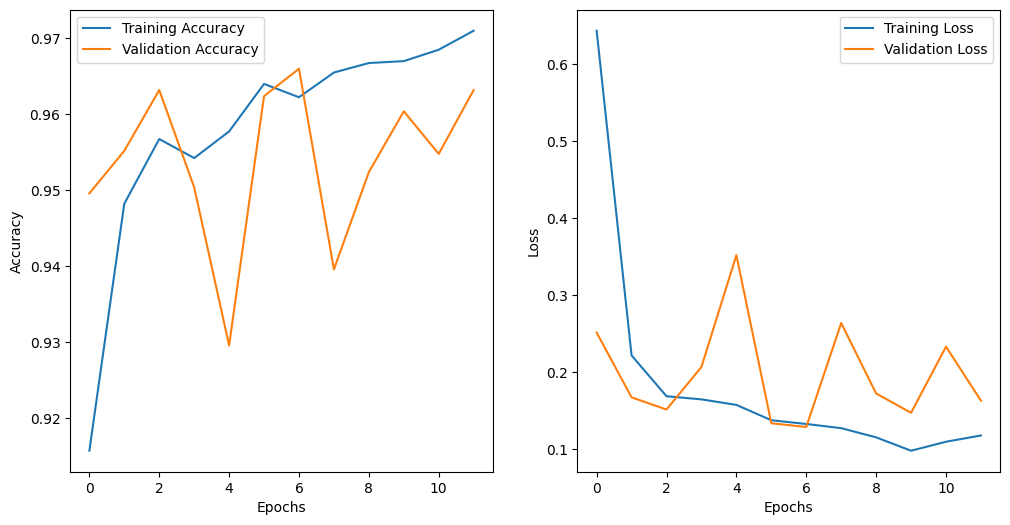

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(inceptionv3_hist.history['acc'], label='Training Accuracy')
plt.plot(inceptionv3_hist.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(inceptionv3_hist.history['loss'], label='Training Loss')
plt.plot(inceptionv3_hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
model.evaluate(validation_generator)

125/125 [==============================] - 4s 35ms/step - loss: 0.1291 - acc: 0.9660


[0.12911951541900635, 0.9660000205039978]

In [ ]:
predictions = model.predict(validation_generator).flatten()
y_pred = (predictions > 0.5).astype(int)

125/125 [==============================] - 12s 71ms/step


In [ ]:
misclassified_indices = np.where(y_pred != validation_generator.classes)[0]
num_misclassified = len(misclassified_indices)
print("Number of misclassified images:", num_misclassified)

Number of misclassified images: 85


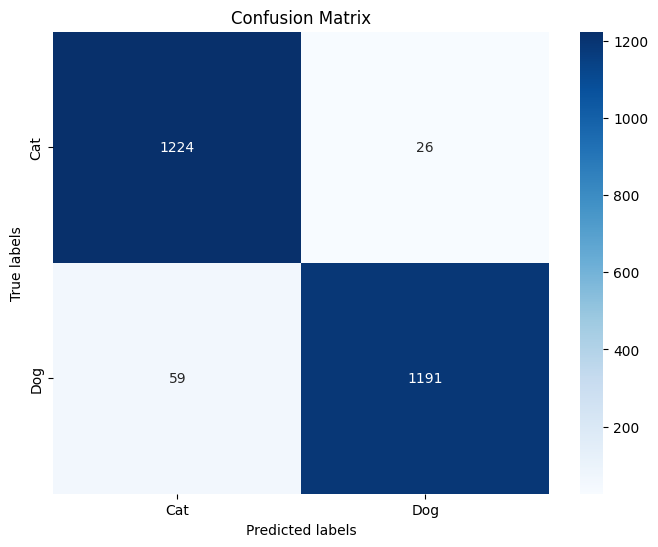

In [ ]:
cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(validation_generator.classes, y_pred, target_names=['Cat', 'Dog']))

              precision    recall  f1-score   support

         Cat       0.95      0.98      0.97      1250
         Dog       0.98      0.95      0.97      1250

    accuracy                           0.97      2500
   macro avg       0.97      0.97      0.97      2500
weighted avg       0.97      0.97      0.97      2500



In [ ]:
sample_indices = np.random.choice(misclassified_indices, size=50, replace=False)

num_cols = 8
num_rows = int(np.ceil(len(sample_indices) / num_cols))

plt.figure(figsize=(30, 30))
for i, idx in enumerate(sample_indices):
    img_path = validation_generator.filepaths[idx]
    img = mpimg.imread(img_path)
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    plt.title(f"True: {validation_generator.classes[idx]}, Predicted: {y_pred[idx]}")
    plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.